In [2]:
column_names = ["label", "lepton  pT", "lepton  eta", "lepton  phi", "missing energy magnitude", "missing energy phi", "jet 1 pt", "jet 1 eta", "jet 1 phi", "jet 1 b-tag", "jet 2 pt", "jet 2 eta", "jet 2 phi", "jet 2 b-tag", "jet 3 pt", "jet 3 eta", "jet 3 phi", "jet 3 b-tag", "jet 4 pt", "jet 4 eta", "jet 4 phi", "jet 4 b-tag", "m_jj", "m_jjj", "m_lv", "m_jlv", "m_bb", "m_wbb", "m_wwbb"]


In [3]:
len(column_names)

29

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load and prepare data
df = pd.read_csv("/content/challenge_higgs_data.csv")
df.columns = column_names
features = df.iloc[:, 1:-1]  # all 28 features

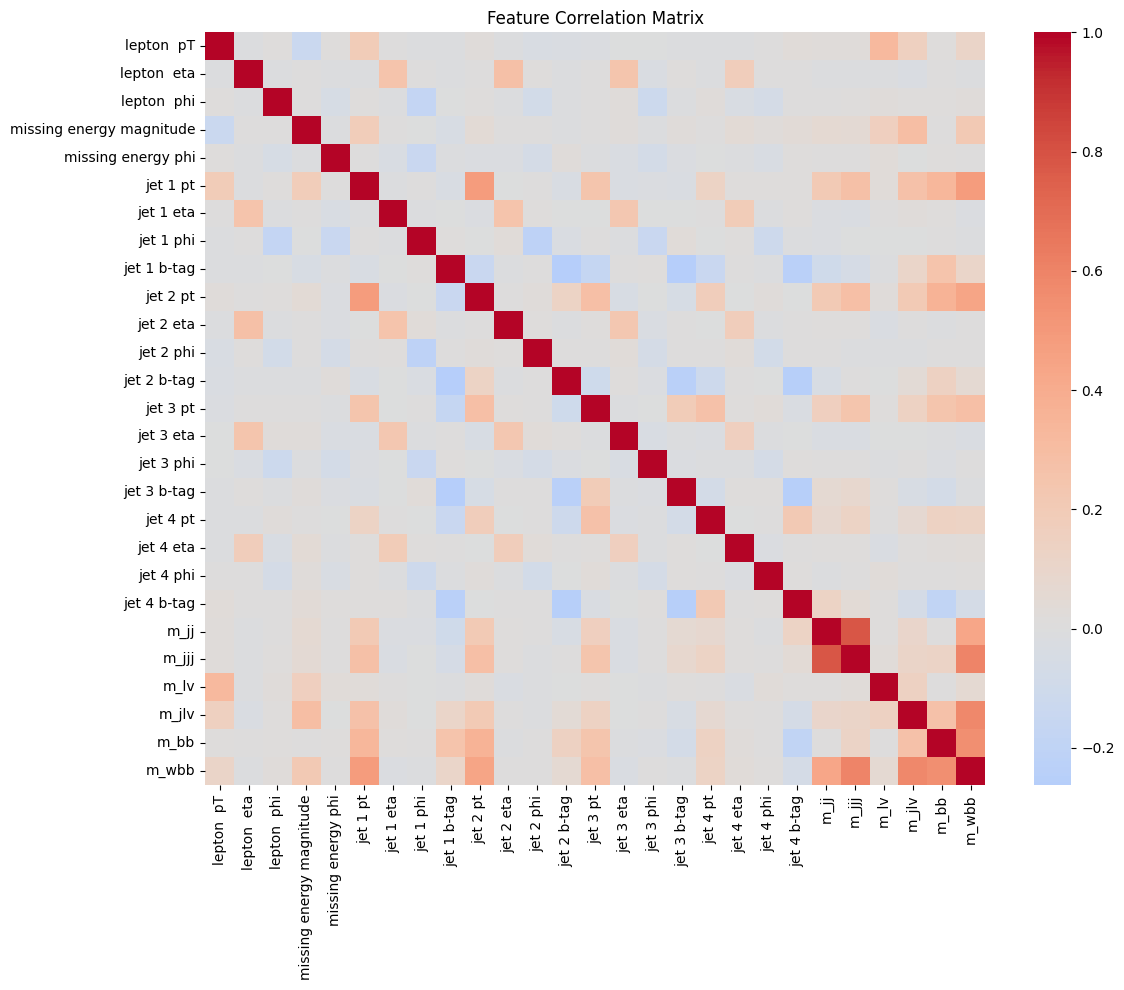

In [5]:
# Compute correlation
corr_matrix = features.corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [ ]:
!pip install pennylane

In [7]:
# Absolute correlation matrix
abs_corr = corr_matrix.abs()

# Select upper triangle (to avoid duplicate pairs)
upper = abs_corr.where(np.triu(np.ones(abs_corr.shape), k=1).astype(bool))

# Find columns to drop
drop_columns = [column for column in upper.columns if any(upper[column] > 0.9)]

print(f"Highly correlated features: {drop_columns}")

# Reduce feature set
features_uncorrelated = features.drop(columns=drop_columns)

Highly correlated features: []


In [8]:
from sklearn.preprocessing import StandardScaler

# Separate labels and features
labels = df.iloc[:, 0]              # First column = labels (0 or 1)
features = df.iloc[:, 1:]           # Columns 2 to end = features

# Apply standardization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Combine back into a DataFrame if needed
df_scaled = pd.concat([
    labels.reset_index(drop=True),
    pd.DataFrame(features_scaled, columns=features.columns)
], axis=1)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Load dataset
df = df_scaled

# Extract features and labels
X = df.iloc[:, 1:].values.astype(np.float32)  # features (columns 1–28)
y = df.iloc[:, -0].values.astype(np.int64)      # target label (first column)

# Optional: use only high-level features
# X = df.iloc[:, 22:].values.astype(np.float32)  # columns 22–28

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=36, stratify=y
)

In [10]:
unique, counts = np.unique(y_train, return_counts=True)
label_distribution = dict(zip(unique, counts))
print(label_distribution)

{np.int64(0): np.int64(1875), np.int64(1): np.int64(1875)}


Dataset shape: (5000, 29)
First few rows:
   1.000000000000000000e+00  8.692932128906250000e-01  \
0                       0.0                  1.043884   
1                       1.0                  0.889241   
2                       1.0                  1.468282   
3                       0.0                  0.642179   
4                       0.0                  2.032682   

   -6.350818276405334473e-01  2.256902605295181274e-01  \
0                   0.040853                 -0.851956   
1                   0.741136                 -0.612256   
2                  -0.407173                  0.602441   
3                  -0.788969                 -0.425820   
4                  -1.414257                 -0.920204   

   3.274700641632080078e-01  -6.899932026863098145e-01  \
0                  0.487162                   1.344852   
1                  0.536777                  -0.637018   
2                  1.607870                   0.053964   
3                  0.505537       

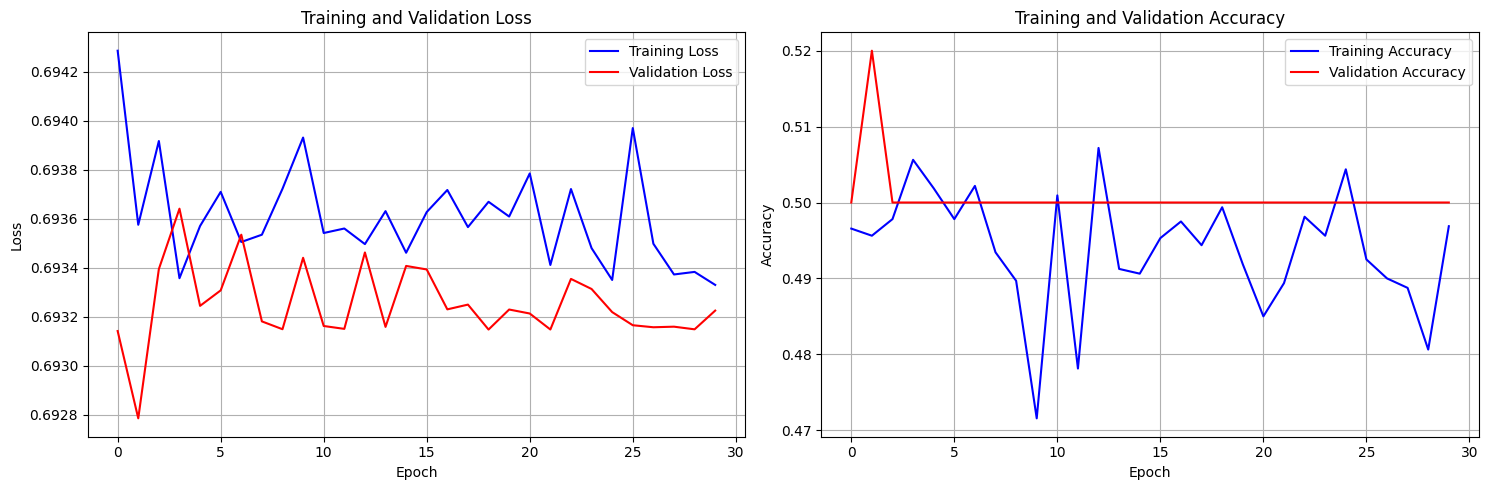

Confusion Matrix:
[[358  42]
 [355  45]]
Test Accuracy: 0.5038


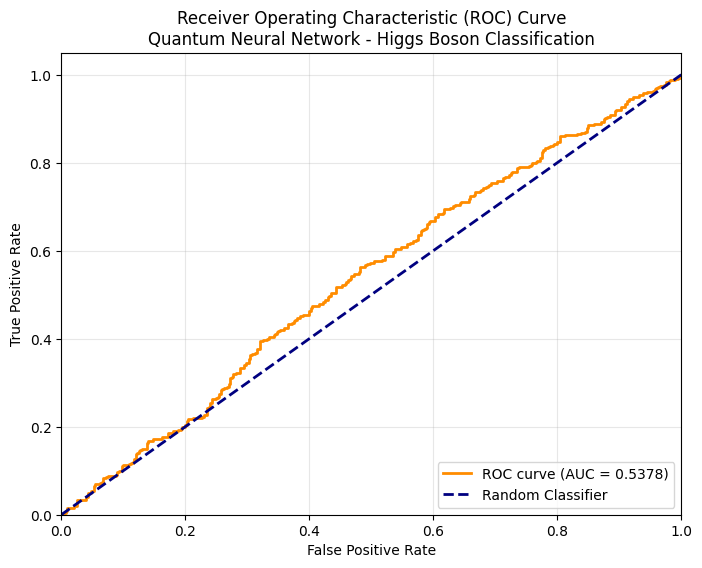

ROC AUC Score: 0.5378


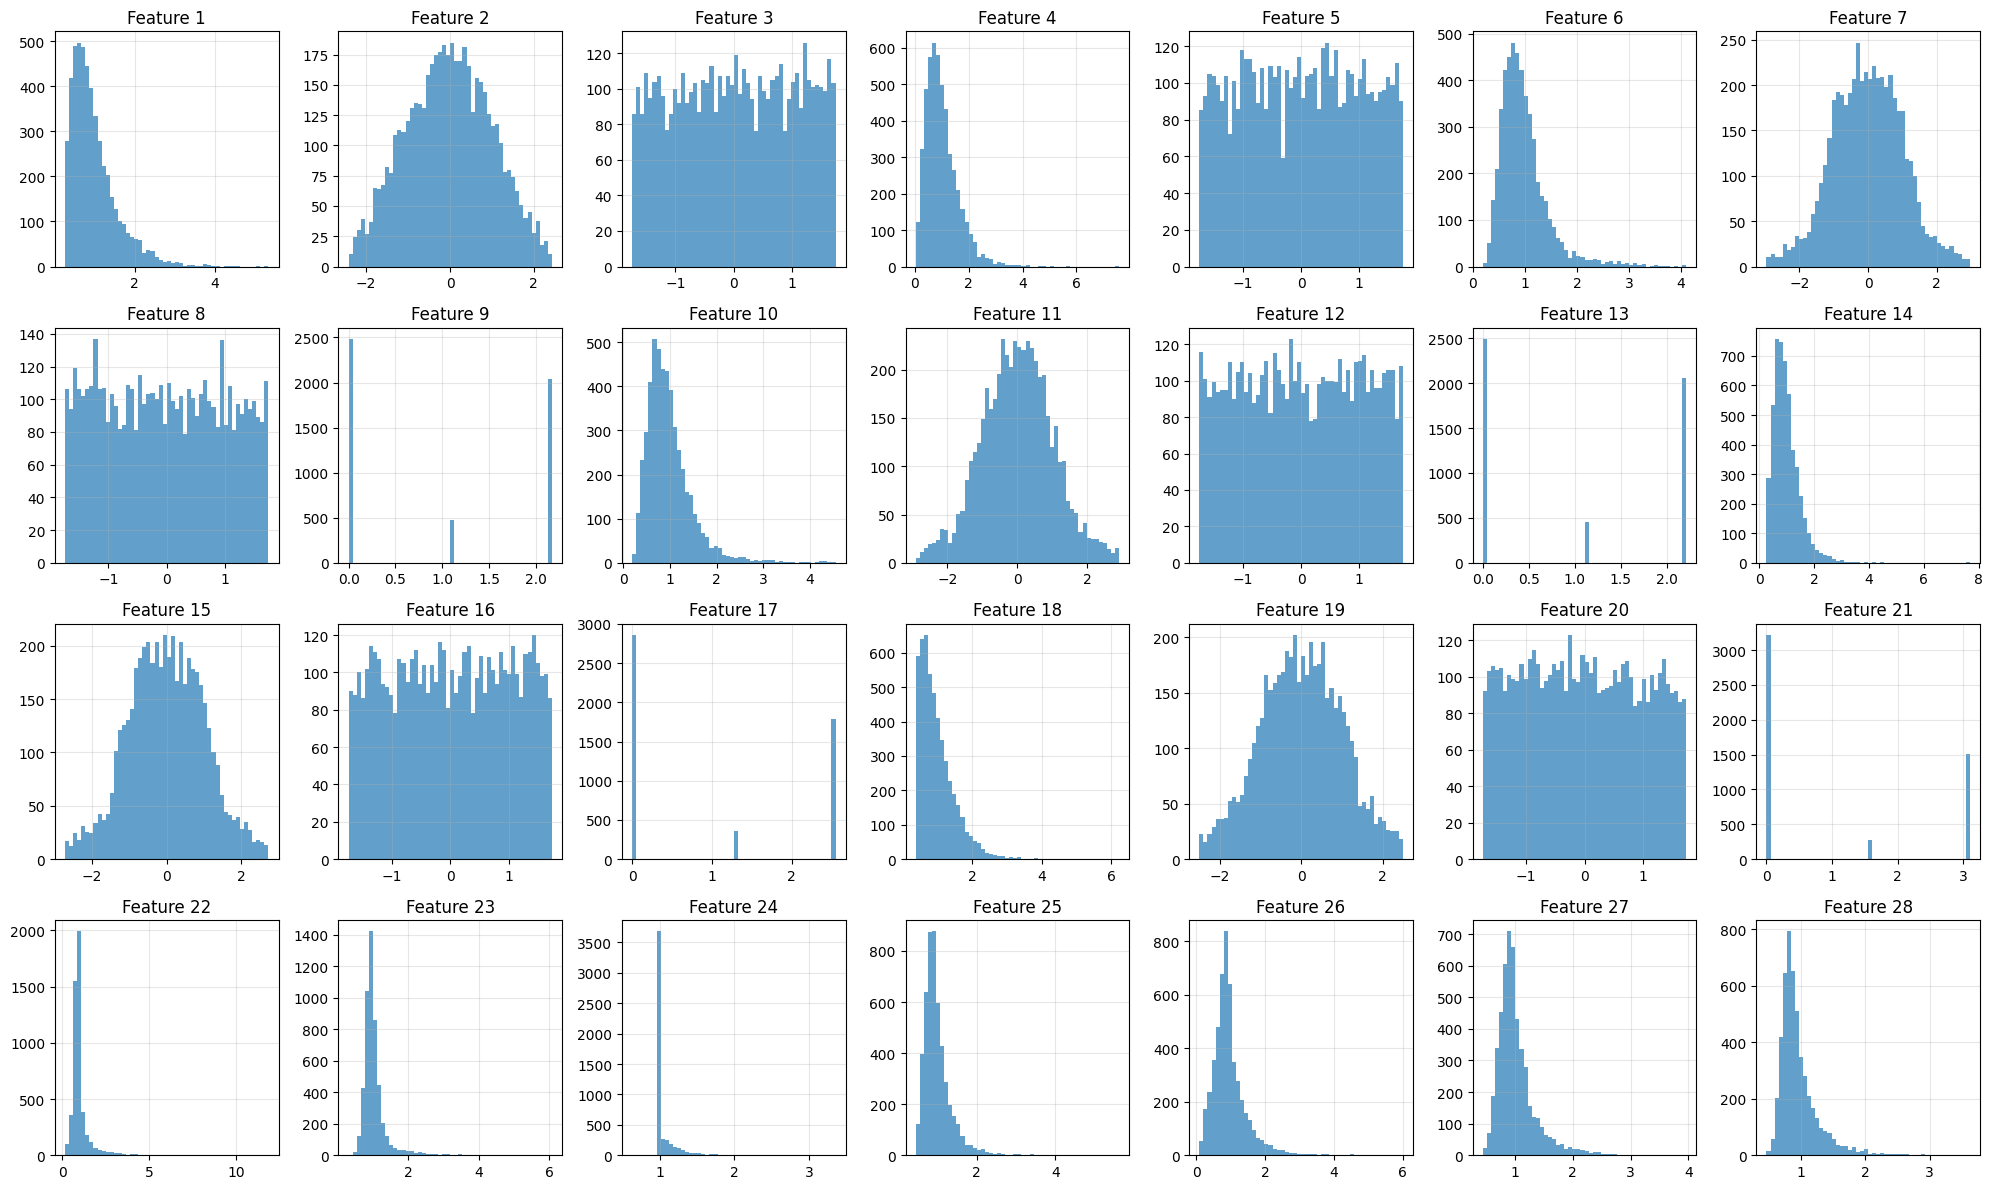

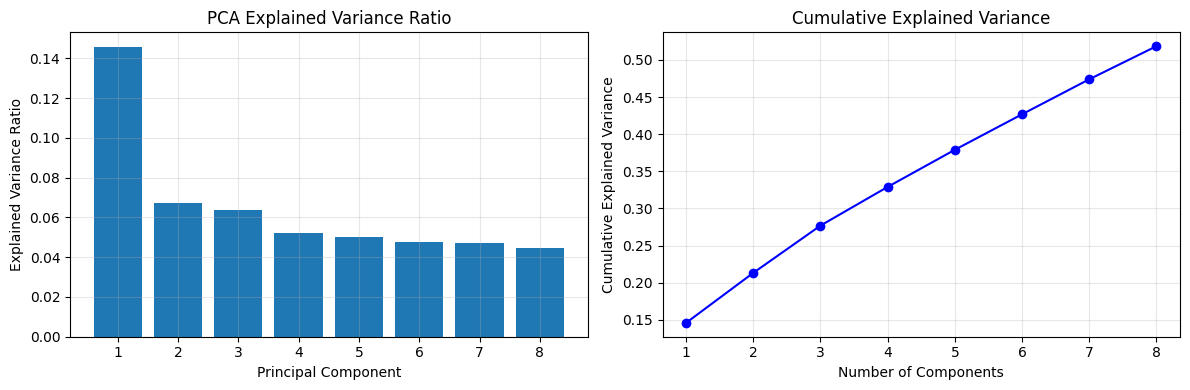

TRAINING COMPLETE!
Final Test Accuracy: 0.5038
Final ROC AUC: 0.5378
Total Model Parameters: 134
Number of Qubits Used: 8
Number of Quantum Layers: 4


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import pennylane as qml
from pennylane import numpy as np

from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import time

# For reproducibility
np.random.seed(1337)
torch.manual_seed(1337)

# ========================================
# 2. DATA LOADING AND PREPROCESSING
# ========================================



# Load the dataset
data_path = 'challenge_higgs_data.csv'  # Adjust path as needed
data = pd.read_csv(data_path)

print(f"Dataset shape: {data.shape}")
print(f"First few rows:")
print(data.head())

# Separate features and labels
X = data.iloc[:, 1:]  # All columns except first (features)
y = data.iloc[:, 0]   # First column (labels: 1 for signal, 0 for background)

print(f"Features shape: {X.shape}")
print(f"Labels distribution:")
print(y.value_counts())

# ========================================
# 3. DATA PREPROCESSING
# ========================================

def preprocess_data(X, y, test_size_val=0.2, test_size_test=0.2, n_components=8):
    """
    Comprehensive data preprocessing pipeline
    """
    # Split the data
    X_train_full, X_val, y_train_full, y_val = train_test_split(
        X, y, test_size=test_size_val, random_state=42, stratify=y
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X_train_full, y_train_full, test_size=test_size_test, random_state=42, stratify=y_train_full
    )

    print(f"Training set size: {X_train.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")

    # Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Dimensionality reduction using PCA (important for quantum circuits)
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")

    # Normalize to [0, 2π] for quantum encoding
    normalizer = MinMaxScaler(feature_range=(0, 2*np.pi))
    X_train_final = normalizer.fit_transform(X_train_pca)
    X_val_final = normalizer.transform(X_val_pca)
    X_test_final = normalizer.transform(X_test_pca)

    return (X_train_final, X_val_final, X_test_final,
            y_train.values, y_val.values, y_test.values,
            scaler, pca, normalizer)

# Apply preprocessing
(X_train, X_val, X_test, y_train, y_val, y_test,
 scaler, pca, normalizer) = preprocess_data(X, y, n_components=8)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

dataloaders = {
    "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    "validation": DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
    "test": DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
}

dataset_sizes = {
    "train": len(train_dataset),
    "validation": len(val_dataset),
    "test": len(test_dataset)
}

print(f"Dataset sizes: {dataset_sizes}")

# ========================================
# 4. QUANTUM NEURAL NETWORK DEFINITION
# ========================================

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Quantum device setup
n_qubits = 8  # Must be <= 20 as per challenge requirements
n_layers = 4

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    """
    Quantum variational circuit with data encoding and variational layers
    """
    # Data encoding using angle embedding
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    # Variational layers
    for layer in range(n_layers):
        # Parameterized rotations
        for qubit in range(n_qubits):
            qml.RY(weights[layer, qubit, 0], wires=qubit)
            qml.RZ(weights[layer, qubit, 1], wires=qubit)

        # Entangling gates
        for qubit in range(n_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])
        # Add circular entanglement
        if n_qubits > 2:
            qml.CNOT(wires=[n_qubits - 1, 0])

    # Measurements
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(2)]  # Measure first 2 qubits

class HybridQuantumNet(nn.Module):
    """
    Hybrid Quantum-Classical Neural Network for Higgs Boson Classification
    """

    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers

        # Quantum layer weights
        weight_shapes = {"weights": (n_layers, n_qubits, 2)}
        self.quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

        # Classical post-processing layers
        self.fc1 = nn.Linear(2, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 2)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Quantum processing
        x = self.quantum_layer(x)

        # Classical post-processing
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Initialize the model
model = HybridQuantumNet(n_qubits, n_layers).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters: {total_params}")

# ========================================
# 5. TRAINING SETUP
# ========================================

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    """
    Training function with tracking of metrics
    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')

    # For plotting
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    print("Training started:")
    print("-" * 50)

    for epoch in range(num_epochs):
        epoch_metrics = {}

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            n_samples = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                n_samples += inputs.size(0)

            epoch_loss = running_loss / n_samples
            epoch_acc = running_corrects.double() / n_samples

            epoch_metrics[f"{phase}_loss"] = epoch_loss
            epoch_metrics[f"{phase}_acc"] = epoch_acc.item()

            # Store metrics for plotting
            if phase == "train":
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())

        # Step scheduler
        if scheduler:
            scheduler.step()

        # Print epoch results
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {epoch_metrics["train_loss"]:.4f} Acc: {epoch_metrics["train_acc"]:.4f}')
        print(f'  Val Loss: {epoch_metrics["validation_loss"]:.4f} Acc: {epoch_metrics["validation_acc"]:.4f}')

        # Save best model
        if epoch_metrics["validation_acc"] > best_acc:
            best_acc = epoch_metrics["validation_acc"]
            best_model_wts = copy.deepcopy(model.state_dict())

        if epoch_metrics["validation_loss"] < best_loss:
            best_loss = epoch_metrics["validation_loss"]

        print("-" * 30)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accs, val_accs

# ========================================
# 6. MODEL TRAINING
# ========================================

print("Starting training...")
trained_model, train_losses, val_losses, train_accs, val_accs = train_model(
    model, criterion, optimizer, scheduler, num_epochs=30
)

# Save the trained model
torch.save(trained_model.state_dict(), 'quantum_higgs_model.pth')
print("Model saved as 'quantum_higgs_model.pth'")

# ========================================
# 7. PLOTTING TRAINING METRICS
# ========================================

# Plot training and validation metrics
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Training Loss', color='blue')
ax1.plot(val_losses, label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accs, label='Training Accuracy', color='blue')
ax2.plot(val_accs, label='Validation Accuracy', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# ========================================
# 8. MODEL EVALUATION
# ========================================

# Evaluate on test set
trained_model.eval()
test_outputs = []
test_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)
        outputs = trained_model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        test_outputs.append(probabilities.cpu())
        test_labels.append(labels)

# Concatenate all predictions
y_pred_proba = torch.cat(test_outputs, dim=0).numpy()
y_test_eval = torch.cat(test_labels, dim=0).numpy()
y_pred = y_pred_proba[:, 1]  # Probability of class 1 (signal)

# Print confusion matrix
y_pred_class = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test_eval, y_pred_class)
print("Confusion Matrix:")
print(cm)

# Calculate accuracy
accuracy = accuracy_score(y_test_eval, y_pred_class)
print(f"Test Accuracy: {accuracy:.4f}")

# ========================================
# 9. ROC CURVE PLOTTING
# ========================================

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_eval, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nQuantum Neural Network - Higgs Boson Classification')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

# ========================================
# 10. FEATURE VISUALIZATION
# ========================================

# Plot feature distributions for original data
fig, axes = plt.subplots(4, 7, figsize=(20, 12))
axes = axes.ravel()

for i in range(min(28, len(X.columns))):
    X.iloc[:, i].hist(bins=50, ax=axes[i], alpha=0.7)
    axes[i].set_title(f'Feature {i+1}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot PCA components
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.title('PCA Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 60)
print("TRAINING COMPLETE!")
print("=" * 60)
print(f"Final Test Accuracy: {accuracy:.4f}")
print(f"Final ROC AUC: {roc_auc:.4f}")
print(f"Total Model Parameters: {total_params}")
print(f"Number of Qubits Used: {n_qubits}")
print(f"Number of Quantum Layers: {n_layers}")
print("=" * 60)